In [ ]:
import os
import random
import numpy as np
from scripts.features_selection import run_cross_direction_shap, merge_shap_stability
# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

# ============================================================
# MODEL CONFIGS
# ============================================================
params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.0166,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.6456,
    "bagging_fraction": 0.8113,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_gain_to_split": 0.049,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}
params_reg = params_bin.copy()
params_reg.update({"objective": "regression", "metric": "rmse"})

# ============================================================
# RUN BOTH DIRECTIONS
# ============================================================
base_dir = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/"
OUTPUT_DIR = f"{base_dir}/shap_results/bidirectional/all_features"

# Direction 1: X1 → X2
shap_bin_fwd, shap_reg_fwd, res_fwd = run_cross_direction_shap(
    train_path=f"{base_dir}/X1_all_rank_features_with_y.tsv",
    val_path=f"{base_dir}/X2_all_rank_features_with_y.tsv",
    out_dir=OUTPUT_DIR,
    tag="X1_to_X2",
    TARGET_BINARY=TARGET_BINARY,
    TARGET_RANK=TARGET_RANK,
    META_COLS=META_COLS,
    chromosomes=chromosomes,
    folds=folds,
    params_bin=params_bin,
    params_reg=params_reg
)

# Direction 2: X2 → X1
shap_bin_rev, shap_reg_rev, res_rev = run_cross_direction_shap(
    train_path=f"{base_dir}/X2_all_rank_features_with_y.tsv",
    val_path=f"{base_dir}/X1_all_rank_features_with_y.tsv",
    out_dir=OUTPUT_DIR,
    tag="X2_to_X1",
    TARGET_BINARY=TARGET_BINARY,
    TARGET_RANK=TARGET_RANK,
    META_COLS=META_COLS,
    chromosomes=chromosomes,
    folds=folds,
    params_bin=params_bin,
    params_reg=params_reg
)


stability_bin = merge_shap_stability(shap_bin_fwd, shap_bin_rev, "binary")
stability_reg = merge_shap_stability(shap_reg_fwd, shap_reg_rev, "regression")



/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM b

# Run the following code to select top-n features

After running the previous cells to get the SHAP stability results, we can select the top-n features from both directions based on their SHAP stability scores.
If the features number is still high, we can further filter them use the same code or remove features with high correlation or high sparsity.
After selecting the features, we can use them for downstream analysis or modeling.

In [ ]:
from scripts.features_selection import select_bidirectional_top_features
base_dir = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/bidirectional/union_features"
output_path = f"{base_dir}/top_features/selected_union_features.tsv"

# select top-n features from both directions
selected_features = select_bidirectional_top_features(
    base_dir=base_dir,
    directions=["X1_to_X2", "X2_to_X1"],
    top_n=30,
    output_path=output_path
)

print(selected_features[:10])  # 顯示前10個選中的特徵
print(f"Total selected features: {len(selected_features)}")



🔄 Processing direction: X1_to_X2
🧩 Extracted 36 unique features from top-30 of binary & regression SHAP summaries.

🔄 Processing direction: X2_to_X1
🧩 Extracted 41 unique features from top-30 of binary & regression SHAP summaries.

✅ Total 64 unique features selected from 2 directions (top 30 each).
💾 Saved combined bidirectional feature list to: ../preprocessed_data/reference/1. merged data/with_y_100_one_side/shap_results/bidirectional/union_features/top_features/selected_union_features.tsv
['cross_DNase_tss_bw_vs_bed_mean_diff', 'DNase_tss_logz_min', 'DNase_tss_logz_min_chr_rank', 'cross_DNase_bw_promoter_gene_delta', 'DNase_tss_logz_max', 'DNase_tss_logz_mean', 'DNase_tss_logz_mean_global_rank', 'H3K4me3_tss_laplacian', 'cross_H3K4me3_gene_bw_over_peak_density', 'DNase_tss_logz_max_global_rank']
Total selected features: 64


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

# ============================================================
# MODEL CONFIGS
# ============================================================
params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.0166,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.6456,
    "bagging_fraction": 0.8113,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_gain_to_split": 0.049,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}
params_reg = params_bin.copy()
params_reg.update({"objective": "regression", "metric": "rmse"})

# ============================================================
# RUN BOTH DIRECTIONS
# ============================================================
base_dir = "../preprocessed_data/reference/1. merged data/with_y_100_one_side/"
OUTPUT_DIR = f"{base_dir}/shap_results/bidirectional/union_features_top30"

all_features = selected_features
# Direction 1: X1 → X2
shap_bin_fwd, shap_reg_fwd, res_fwd = run_cross_direction_shap(
    train_path=f"{base_dir}/X1_all_rank_features_with_y.tsv",
    val_path=f"{base_dir}/X2_all_rank_features_with_y.tsv",
    out_dir=OUTPUT_DIR,
    tag="X1_to_X2",
    TARGET_BINARY=TARGET_BINARY,
    TARGET_RANK=TARGET_RANK,
    META_COLS=META_COLS,
    chromosomes=chromosomes,
    folds=folds,
    params_bin=params_bin,
    params_reg=params_reg,
    feature_cols=all_features
)

# Direction 2: X2 → X1
shap_bin_rev, shap_reg_rev, res_rev = run_cross_direction_shap(
    train_path=f"{base_dir}/X2_all_rank_features_with_y.tsv",
    val_path=f"{base_dir}/X1_all_rank_features_with_y.tsv",
    out_dir=OUTPUT_DIR,
    tag="X2_to_X1",
    TARGET_BINARY=TARGET_BINARY,
    TARGET_RANK=TARGET_RANK,
    META_COLS=META_COLS,
    chromosomes=chromosomes,
    folds=folds,
    params_bin=params_bin,
    params_reg=params_reg,
    feature_cols=all_features
)


stability_bin = merge_shap_stability(shap_bin_fwd, shap_bin_rev, "binary", OUTPUT_DIR)
stability_reg = merge_shap_stability(shap_reg_fwd, shap_reg_rev, "regression", OUTPUT_DIR)




🚀 Running SHAP cross-direction: X1_to_X2
📊 Using 63 features

🧩 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
📈 Binary Classifier: AUC=0.9244, F1=0.8462


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7960 | (masked @>0.4) = 0.8156


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 2 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
📈 Binary Classifier: AUC=0.9192, F1=0.8374


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.8036 | (masked @>0.4) = 0.8202


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 3 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
📈 Binary Classifier: AUC=0.9254, F1=0.8515


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.8029 | (masked @>0.4) = 0.8148


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 4 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
📈 Binary Classifier: AUC=0.9255, F1=0.8486


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.8057 | (masked @>0.4) = 0.8156


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
📈 Binary Classifier: AUC=0.9280, F1=0.8239


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7915 | (masked @>0.4) = 0.8037


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



===== 📊 OVERALL PERFORMANCE =====
   fold       auc        f1   rho_reg  rho_masked
0     1  0.924425  0.846171  0.796020    0.815590
1     2  0.919209  0.837358  0.803597    0.820151
2     3  0.925412  0.851479  0.802893    0.814797
3     4  0.925458  0.848555  0.805691    0.815628
4     5  0.928013  0.823929  0.791533    0.803697

Mean Spearman ρ (raw):     0.7999
Mean Spearman ρ (masked):  0.8140
Mean AUC (binary):         0.9245
Mean F1 (binary):          0.8415

🚀 Running SHAP cross-direction: X2_to_X1
📊 Using 63 features

🧩 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
📈 Binary Classifier: AUC=0.9345, F1=0.8322


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7812 | (masked @>0.4) = 0.8116


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 2 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
📈 Binary Classifier: AUC=0.9354, F1=0.8439


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7840 | (masked @>0.4) = 0.8167


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 3 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
📈 Binary Classifier: AUC=0.9362, F1=0.8372


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7898 | (masked @>0.4) = 0.8133


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 4 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
📈 Binary Classifier: AUC=0.9299, F1=0.8278


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7833 | (masked @>0.4) = 0.8088


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



🧩 Fold 5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
📈 Binary Classifier: AUC=0.9340, F1=0.8319


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


📊 Spearman ρ (raw) = 0.7742 | (masked @>0.4) = 0.8100


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



===== 📊 OVERALL PERFORMANCE =====
   fold       auc        f1   rho_reg  rho_masked
0     1  0.934479  0.832201  0.781168    0.811552
1     2  0.935359  0.843864  0.784019    0.816693
2     3  0.936152  0.837209  0.789756    0.813336
3     4  0.929899  0.827800  0.783350    0.808778
4     5  0.934015  0.831939  0.774249    0.810031

Mean Spearman ρ (raw):     0.7825
Mean Spearman ρ (masked):  0.8121
Mean AUC (binary):         0.9340
Mean F1 (binary):          0.8346



📊 Total feature count (before pruning): 239
✅ Loaded X1: shape=(16284, 2914)
✅ Loaded X2: shape=(16284, 2914)
✅ Loaded X3: shape=(1984, 2914)

🧹 Removing sparse features (non-zero ratio < 1.00%) ...
🚫 Found 0 sparse features to remove (avg non-zero ratio < 0.01)
✅ Remaining features after sparsity filtering: 239
🧩 X1: 379 correlated pairs → 146 features with |r| > 0.99
🧩 X2: 306 correlated pairs → 142 features with |r| > 0.99
🧩 X3: 802 correlated pairs → 162 features with |r| > 0.99

🔗 Union (any cell) high corr features: 164
🔗 Intersection (all cell) high corr features: 134

✅ Remaining features after pruning: 75 (removed 164)

📈 Visualizing correlation matrix for X1 after pruning ...


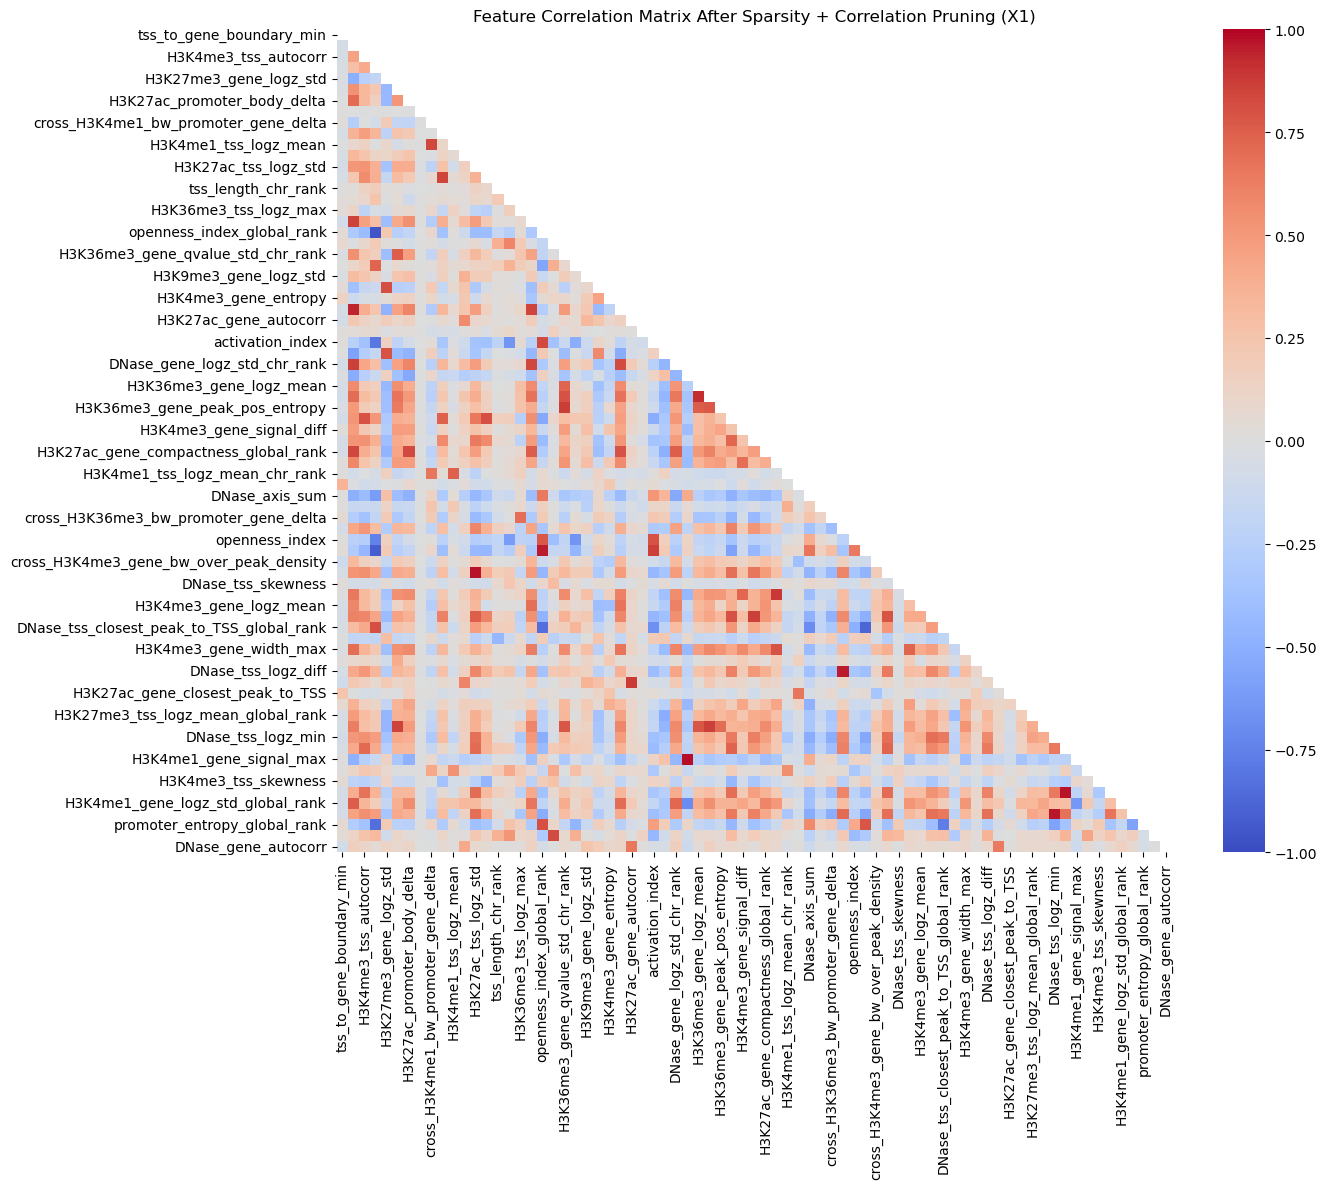

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.features_selection import get_high_corr_pairs, remove_sparse_features
# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. merged data/without_y_100_one_side"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "rank_global", "rank_chr"]

THRESHOLD = 0.99  # 高相關閾值
SPARSITY_THRESHOLD = 0.01  # 小於此比例的非零值會被刪除（例如 <1% 非零）


# ============================================================
# LOAD ALL CELLS
# ============================================================
feature_cols = selected_features
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df[feature_cols]
    print(f"✅ Loaded {cell}: shape={df.shape}")

# 
# --- 執行稀疏特徵過濾 ---
feature_cols, zero_df = remove_sparse_features(dfs, feature_cols, threshold=SPARSITY_THRESHOLD)
print(f"✅ Remaining features after sparsity filtering: {len(feature_cols)}")

# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_feats_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    high_corr_feats_per_cell[cell] = high_corr_feats
    print(f"🧩 {cell}: {len(pairs)} correlated pairs → {len(high_corr_feats)} features with |r| > {THRESHOLD}")

# ============================================================
# COMBINE RESULTS ACROSS CELLS
# ============================================================
union_feats = set().union(*high_corr_feats_per_cell.values())
intersection_feats = set.intersection(*high_corr_feats_per_cell.values())

print(f"\n🔗 Union (any cell) high corr features: {len(union_feats)}")
print(f"🔗 Intersection (all cell) high corr features: {len(intersection_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES (use union)
# ============================================================
features_pruned = [f for f in feature_cols if f not in union_feats]
print(f"\n✅ Remaining features after pruning: {len(features_pruned)} (removed {len(union_feats)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
# for cell, df in dfs.items():
#     df_pruned = df[META_COLS + features_pruned]
#     out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
#     df_pruned.to_csv(out_path, sep="\t", index=False)
#     print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Sparsity + Correlation Pruning (X1)")
    plt.tight_layout()
    plt.show()
